# Project: Group company by topic modeling on news feed
## Citation

1. "Topic Modeling in Embedding Spaces" (ETM) by Adji B. Dieng, Francisco J. R. Ruiz, and David M. Blei. (Arxiv link: https://arxiv.org/abs/1907.04907)  
2. https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb   
## Dependencies  
    python 3.6.7 +  
    pytorch 1.1.0 + 


## Business Problems
* To discover common topics from the news feed on company 
* To define similarity between companies based on topic covered on content of the news  
* To perform finaicial analysis based on similarity of companies  

## Analytic Approach
1. ETM
* Unsupervised Learning Algorithm 
* Bag of Words Model
* ETM defines words and topics in the same embedding space. The likelihood of a word under ETM is a Categorical whose natural parameter is given by the dot product between the word embedding and its assigned topic's embedding. ETM is a document model that learns interpretable topics and word embeddings and is robust to large vocabularies that include rare words and stop words.
2. models.atmodel – Author-topic models https://radimrehurek.com/gensim/models/atmodel.html
* ticket number as author  

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data Requirements  
### Data Source:  


In [2]:
import lib.ETM_Databunch as db
import pandas as pd

colname = "TXT"

In [3]:
import sqlite3
import pandas as pd

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
 
    return conn

def getNews(conn):
    """
    :param conn: the Connection object
    :tablename
    :return: df
    """
    query = '''
    select 
	    a.symbol, 
        a.industry as industry,
	    a.descript, 
	    b.DATE_PUB DATE,
	    b.title,
	    c.txt
    from 
	    master_ext as a,
	    news_master as b,
	    news_content as c
    where
	    a.id = b.sm_id and
	    b.id = c. nm_id;
    '''
    return pd.read_sql_query(query, conn)

conn = create_connection("./data/test.db")
df_all = getNews(conn)
df = df_all

In [4]:
df['industry'] = [e.split('—')[0] for e in df.industry]

In [5]:
df = df[df.industry.str.len() > 1]

In [6]:
print(len(df))
df.head()

9807


,symbol,industry,descript,DATE,TITLE,TXT
0,ABX,Gold,BARRICK GOLD CORP.,2017-07-10 15:15:45 +0000,"CANADA STOCKS-TSX edges higher on materials, e...","* TSX up 15.17 points, or 0.1 percent, to 15,0..."
1,ABX,Gold,BARRICK GOLD CORP.,2017-07-10 02:50:00 +0000,BARRICK GOLD 24 HOUR DEADLINE ALERT: APPROXIMA...,"NEW ORLEANS, July 9, 2017 /PRNewswire/ -- Clai..."
2,ACD,Credit Services,ACCORD FINANCIAL,2017-04-17 14:13:00 +0000,Accord Declares Regular Quarterly Dividend of ...,"TORONTO , April 17, 2017 /CNW/ - Accord Financ..."
3,ACD,Credit Services,ACCORD FINANCIAL,2017-01-27 14:00:00 +0000,Accord Declares Regular Quarterly Dividend of ...,"TORONTO , Jan. 27, 2017 /CNW/ - Accord Financi..."
4,ACQ,Auto & Truck Dealerships,AUTOCANADA INC,2017-05-05 17:41:01 +0000,Edited Transcript of ACQ.TO earnings conferenc...,Q1 2017 AutoCanada Inc Earnings Call Edmonton ...


In [7]:
df_group = (df[['symbol','industry']].groupby(['industry']).agg(['count']) > 8)['symbol'].reset_index()
l_industry = list(df_group[df_group['count']==True]['industry'])
df1 = df[df.industry.isin(l_industry)]

## Gensim Author Topic Model
* to select relevant keywords for identify industry

In [8]:
from gensim.models import AuthorTopicModel
from gensim.corpora import mmcorpus
from gensim.test.utils import common_dictionary, datapath, temporary_file

def display_dictionary(dict_a, n):
    for x in list(dict_a)[0:n]:
        print ("key {}, value {} ".format(x,  dict_a[x]))
		
def getAuthor2doc(dbunch):
    authors_train = pd.DataFrame({"author": dbunch.authors["train"]})
    authors_train = authors_train.reset_index()
    df1 = authors_train.groupby('author')['index'].apply(list)
    author2doc = df1.to_dict()
    return author2doc

# Run Model
l_words = []
n_topic = 100

for i in range(10):
    print(str(i))

    # Undersampling by industry
    df_sample = pd.DataFrame(columns=['symbol', 'industry', 'descript',	'DATE',	'TITLE', 'TXT'])
    for s in set(df1.industry):
        df_sample = df_sample.append(df1[df1.industry==s].sample(n=15, replace = True))
    df_sample = df_sample.sample(frac=1).reset_index(drop=True)
    df_sample.to_csv("./tmp/news_content.csv", index=False)

    # Load data to databunch for using build-in doc2bow and id2words
    datatm = db.databunch(name="news_content", batch_wd_count=1000)
    datatm.import_data(
            datadir="./tmp", fname="news_content.csv", col_name=colname, col_author="industry",    
            stopword_ext = []   
    )

    # Build corpus and author2doc
    author2doc = getAuthor2doc(datatm)
    corpus = [datatm.id2word.doc2bow(text.strip().split()) for text in datatm.texts["train"]]		
    
    # run model
    model = AuthorTopicModel(corpus, author2doc=author2doc, id2word=datatm.id2word, num_topics=n_topic \
                    ,chunksize=1000, passes=150, gamma_threshold=1e-5, \
                    eval_every=0, iterations=100, random_state=0)
                    
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    print('iter:%d, Topic coherence: %.3e' %(i, tc))

    # capture keywords
    for topic in range(n_topic):
        words = ''
        for word, prob in model.show_topic(topic):
            words = words + word + " "
            l_words.append(word)
        print (str(topic) + ":" + words)

print(list(set(l_words)))

outF = open("./tmp/keywords_client.csv", "w")
outF.write('Topics\n')
for line in list(set(l_words)):
  outF.write(line + "\n")
outF.close()


wing agreements sale accordance senior among two notes 
73:quarter growth product right continue dealer retail increase last good 
74:statements fuel press network credit ended subject convenience care performance 
75:outstanding price indices purchase principal amount changes trade original statements 
76:average moving trading volume research reports three reviewed ended document 
77:net quarter cash operating ended loss months facility rent fourth 
78:ended research moving increase trading average three statements volume press 
79:income increase quarter share pension per statements ended net compared 
80:trading research moving free average stocks statements content report options 
81:quarter fiscal third per earnings operations approximately primarily services foreign 
82:stocks small full estimates cap performance move https companies investors 
83:quarter cash debt net facilities rent compared facility fourth would 
84:moving research average trading reports stocks free construc

## Data Preparation
### EDA

* Number of word per document

number of documents: 9807


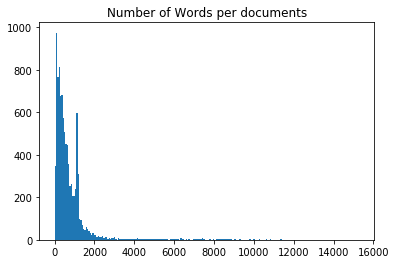

,nw
count,9807.000000
mean,797.568370
std,1217.593189
min,2.000000
25%,235.000000
50%,485.000000
75%,963.000000
max,15274.000000


In [9]:
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt


data_words = [[w for w in simple_preprocess(str(words), deacc=True)] for words in df[colname]]
print("number of documents: " + str(len(data_words)))

numwords = [len(ws) for ws in data_words if len(ws)]
df_n = pd.DataFrame({"nw": numwords})

plt.hist(df_n.nw, bins='auto')  
plt.title("Number of Words per documents")
plt.show()

df_n.describe(percentiles=[.25, .5, .75])

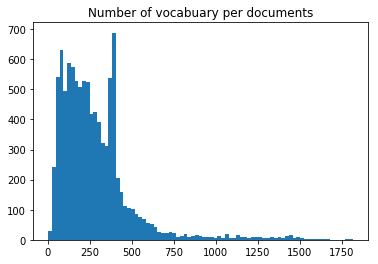

,nw
count,9807.000000
mean,282.020903
std,224.155784
min,2.000000
25%,134.000000
50%,235.000000
75%,376.000000
max,1816.000000


In [10]:
num_keys = [len(set(ws)) for ws in data_words]
df_k = pd.DataFrame({"nw": num_keys})

plt.hist(df_k.nw, bins='auto')  
plt.title("Number of vocabuary per documents")
plt.show()

df_k.describe(percentiles=[.25, .5, .75])


### Load document as databunch

In [11]:
df_all.to_csv("./tmp/news_content.csv",index=False)
datatm = db.databunch(name="news_content", batch_wd_count=300, fp_kw = "./tmp/keywords_client.csv")
datatm.import_data(
    datadir="./tmp", fname="news_content.csv", col_name=colname, col_author="industry",    
    stopword_ext = []   
)

# of docs: 12844


(10405, {'train': 10276, 'test': 1284, 'valid': 1284})

In [12]:
len(set(datatm.authors["test"]))

86

## ETM model construction  

In [13]:
import lib.ETM_Learner as etm_learner
Learner = etm_learner.ETM_Topic_Modeling_Learner(datatm)
Learner(100)

* Measurement of the similarity of topics of parameter Beta 

In [14]:
Learner.fit_one_cycle(1499)

receiving', 'reasonably', 'raymond', 'rationale']
T_6:['statements', 'looking', 'forward', 'future', 'actual', 'risks', 'uncertainties', 'events', 'factors', 'expectations', 'materially', 'cause', 'differ', 'press', 'certain', 'assumptions', 'historical', 'contains', 'regarding']
T_7:['assets', 'companies', 'international', 'corporate', 'sug', 'ronald', 'roll', 'repeat', 'render', 'reminder', 'remind', 'remember', 'relative', 'schedules', 'refresh', 'reconciliation', 'receiving', 'reasonably', 'raymond']
T_8:['lease', 'settlement', 'plc', 'food', 'stockholders', 'uranium', 'retirement', 'joint', 'convertible', 'ten', 'supplemental', 'rental', 'almost', 'interim', 'maintains', 'payments', 'overall', 'texas', 'geographic']
T_9:['class', 'firm', 'action', 'contact', 'period', 'law', 'lead', 'rights', 'would', 'investors', 'purchased', 'statements', 'materially', 'share', 'telephone', 'shareholders', 'advertising', 'public', 'member']
T_10:['news', 'potential', 'many', 'control', 'relative

In [15]:
import math
import scipy
import numpy as np

def upper_tri_masking(A):
    '''
    Return the flattened upper triangle
    '''        
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]


In [16]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

X = Learner.model.get_beta().cpu().detach().numpy()
print("Dimension of Beta:" + str(X.shape))
D = scipy.spatial.distance.cdist(X,X)
print("Dimension of distance matrix:" + str(D.shape))
print(str(D))
Dd = upper_tri_masking(D)
print("Dimension of flattened distance between topics:" + str(Dd.shape))

Dimension of Beta:(100, 10405)
Dimension of distance matrix:(100, 100)
[[0.00 0.72 0.47 ... 0.17 0.69 0.15]
 [0.72 0.00 0.84 ... 0.72 0.98 0.71]
 [0.47 0.84 0.00 ... 0.46 0.82 0.46]
 ...
 [0.17 0.72 0.46 ... 0.00 0.69 0.12]
 [0.69 0.98 0.82 ... 0.69 0.00 0.68]
 [0.15 0.71 0.46 ... 0.12 0.68 0.00]]
Dimension of flattened distance between topics:(4950,)


In [17]:
Learner.predict_data_batch(Learner.databunch.text2DataBatch([Learner.databunch.texts["test"][2]]))

[16]

In [18]:
df_all = etm_learner.report_Results(Learner)
df_all.head()

,TXT,topics
0,U.S. government debt prices were mostly lower ...,"[87, 87]"
1,"VANCOUVER, BRITISH COLUMBIA--(Marketwired - J...","[0, 0]"
2,It commonly happens in stock investing that i...,"[16, 16]"
3,"TORONTO, June 12, 2017 (GLOBE NEWSWIRE) -- Fa...",[37]
4,"MONTREAL, QUEBEC--(Marketwired - Jul 26, 2017)...",[21]


* plot for different parameters  

In [19]:
import math
import scipy
def plotNNparameters(nm, parameter):
    df_k = pd.DataFrame({nm: parameter.flatten().cpu().detach().numpy()})    
    print(str(len(df_k)))
    print("mean:" + str(df_k[nm].mean()) + " std: " + str(df_k[nm].std()))
    s_k = df_k.sample(n=min(len(df_k),1000), random_state=1)
    plt.hist(s_k[nm], 60, facecolor='gray', align='mid')
    plt.title(nm)
    plt.show()
    s_k.describe(percentiles=[.05, .25, .5, .75, .95]) 

In [20]:
print(Learner.model)

ETM(
  (t_drop): Dropout(p=0.6)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=10405, bias=False)
  (alphas): Linear(in_features=300, out_features=100, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=10405, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=100, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=100, bias=True)
)


3121500
mean:0.010197698138654232 std: 1.0594336986541748


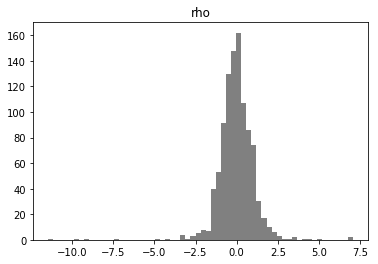

In [21]:
plotNNparameters("rho", Learner.model.rho.weight)

30000
mean:0.0005870789755135775 std: 2.035250186920166


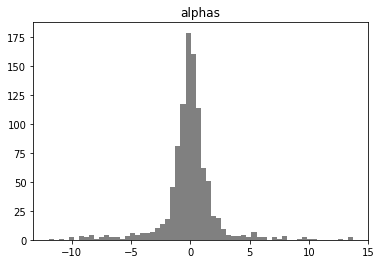

In [22]:
plotNNparameters("alphas", Learner.model.alphas.weight)

8324000
mean:1.3134301298123319e-05 std: 0.0015690439613536


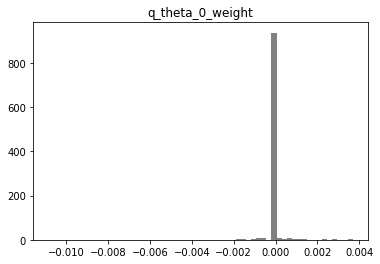

In [23]:
plotNNparameters("q_theta_0_weight", Learner.model.q_theta[0].weight)

800
mean:0.0002015300269704312 std: 0.08026887476444244


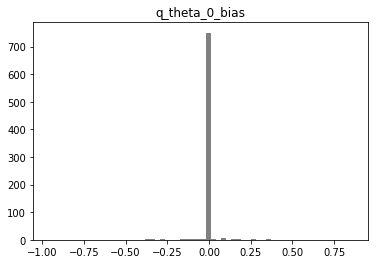

In [24]:
plotNNparameters("q_theta_0_bias", Learner.model.q_theta[0].bias)

640000
mean:0.0008167520281858742 std: 0.056290436536073685


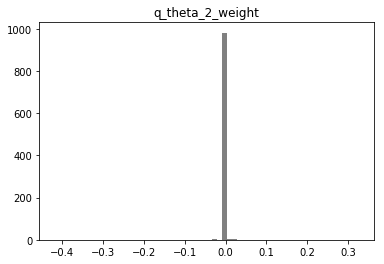

In [25]:
plotNNparameters("q_theta_2_weight", Learner.model.q_theta[2].weight)

800
mean:0.01901399716734886 std: 0.2228645384311676


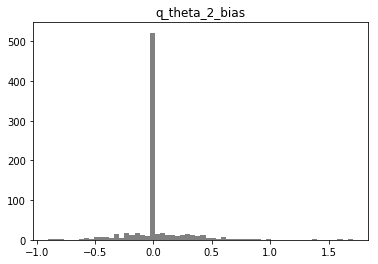

In [26]:
plotNNparameters("q_theta_2_bias", Learner.model.q_theta[2].bias)

80000
mean:-0.00041737480205483735 std: 0.20181798934936523


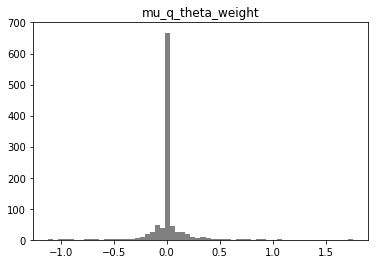

In [27]:
plotNNparameters("mu_q_theta_weight", Learner.model.mu_q_theta.weight)

100
mean:-0.00219665071927011 std: 0.25617387890815735


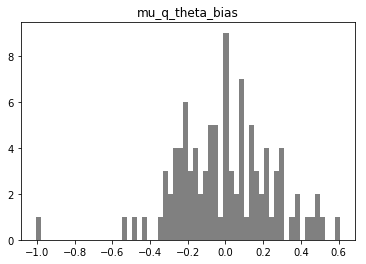

In [28]:
plotNNparameters("mu_q_theta_bias", Learner.model.mu_q_theta.bias)

80000
mean:8.162012818502262e-05 std: 0.015416272915899754


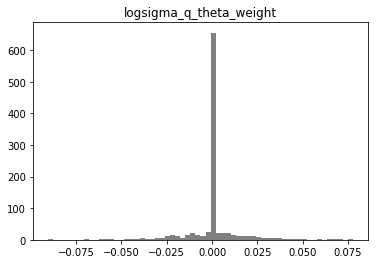

In [29]:
plotNNparameters("logsigma_q_theta_weight", Learner.model.logsigma_q_theta.weight)

100
mean:-0.037386659532785416 std: 0.0897379145026207


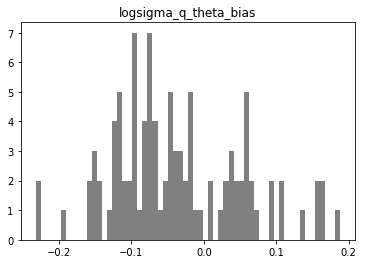

In [30]:
plotNNparameters("logsigma_q_theta_bias", Learner.model.logsigma_q_theta.bias)

## Output Results

In [31]:
def convert_set(df_all):
    t = -1
    keys = [] 
    for e in df_all['topics']:
        key = []
        for ee in e:
            if (int(ee) in key):
                pass
            else:
                key.append(ee)
        keys.append(key)
    return(keys)

In [32]:
df_all = etm_learner.report_Results(Learner)
df_out_1 = df_all.copy()
df_out_1['keys'] = convert_set(df_all)
df_out_1.head(20)

,TXT,topics,keys
0,U.S. government debt prices were mostly lower ...,"[87, 87]",[87]
1,"VANCOUVER, BRITISH COLUMBIA--(Marketwired - J...","[0, 0]",[0]
2,It commonly happens in stock investing that i...,"[16, 16]",[16]
3,"TORONTO, June 12, 2017 (GLOBE NEWSWIRE) -- Fa...",[37],[37]
4,"MONTREAL, QUEBEC--(Marketwired - Jul 26, 2017)...",[21],[21]
5,"SAN JOSE, CA--(Marketwired - May 22, 2017) - ...","[6, 6]",[6]
6,Gain in utilities and telecom stocks led the ...,"[87, 87, 87, 16, 16, 86]","[87, 16, 86]"
7,"VANCOUVER, British Columbia, July 13, 2017 (G...",[18],[18]
8,"WASHINGTON, DC and MONTREAL, CANADA--(Marketw...","[14, 15]","[14, 15]"
9,"NEW YORK, NY / ACCESSWIRE / May 2, 2017 / The...","[9, 9]",[9]


In [33]:
from collections import Counter
from lib.ETM_utils import *
topics = Learner.visualize(show=False)
c = Counter(flatten([set(e) for e in df_all['topics']]))
df_topics = pd.DataFrame({"keywords": topics, "count": [c[i] for i in range(len(topics))]})

In [34]:
arr_topic = np.zeros([len(df_all), len(df_topics)], dtype=int)
for row, e in enumerate(df_out_1.topics):
    for ee in e:
        arr_topic[row][ee] = arr_topic[row][ee] + 1

df_topic_array = pd.DataFrame(arr_topic)    
df_topic_array.columns = ["T" + str(e) for e in df_topic_array.columns]
df_topic_array.head()
out = pd.merge(df_out_1, df_topic_array, left_index = True, right_index = True)
out['zkeys'] = [[str(t).zfill(3)  for t in ts] for ts in out['keys']]
out.head()

,TXT,topics,keys,T0,T1,T2,T3,T4,T5,T6,...,T91,T92,T93,T94,T95,T96,T97,T98,T99,zkeys
0,U.S. government debt prices were mostly lower ...,"[87, 87]",[87],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[087]
1,"VANCOUVER, BRITISH COLUMBIA--(Marketwired - J...","[0, 0]",[0],2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[000]
2,It commonly happens in stock investing that i...,"[16, 16]",[16],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[016]
3,"TORONTO, June 12, 2017 (GLOBE NEWSWIRE) -- Fa...",[37],[37],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[037]
4,"MONTREAL, QUEBEC--(Marketwired - Jul 26, 2017)...",[21],[21],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[021]


In [35]:
out.to_csv('./data/texts.csv', index=False)
df_topics.to_csv('./data/topics.csv', index=True)

## Archived Model

In [36]:
import lib.ETM_Learner as etm_learner
etm_learner.save(Learner)
Learner = etm_learner.load()

In [37]:
colname="TXT"
rpt_key = "20200119_2"
etm_learner.archiveModel(rpt_key, Learner)

'.//models//20200119_2//log//rpt_20200119_2.log'